# SVAE Training Results

In this notebook, we will analyze the result reports we generated during hyperparameter tuning step. To do that, we will just import the report files and go through them.

The results in this report are updated versions of the previous notebook based on the feedbacks received from thesis supervisors.

In [1]:
import sys
import torch
import argparse
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from custom_reg_dataset import RegisterDataset
from datetime import datetime, timedelta
from timeit import default_timer as timer
import time
from statistics import mean as mean_calc
import numpy as np

import os

import pytorch_warmup as warmup

from models.SVAE import SVAE
#from custom_dataset import TerraDataset
from utils.loss_fn import loss_fn_SVAE

from pytorchtools import EarlyStopping

from training_methods import cv_fold_maker, hyperparameter_tuner, model_test

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


## High-dimensional Data Results

In [2]:
os.getcwd()

'H:\\Projects\\My Thesis'

In [3]:
data_reports = "H:\Projects\My Thesis\hyperparameter_reports\\FINALS\\"

In [4]:
data_reports

'H:\\Projects\\My Thesis\\hyperparameter_reports\\FINALS\\'

In [6]:
highdim_report_step1 = pd.read_csv(os.path.join(data_reports,
                                                  "08-05-2023_17-26-11_SVAE_hyperparameter_tuning_report_highdim_step1.txt"),
                                                  sep = "\t")
highdim_report_step2 = pd.read_csv(os.path.join(data_reports,
                                                  "15-05-2023_01-44-25_SVAE_hyperparameter_tuning_report_highdim_step2.txt"),
                                                  sep = "\t")
highdim_report_valtest = pd.read_csv(os.path.join(data_reports,
                                                  "highdim_data_valtest_report_16-05-2023_10-06-19.txt"),
                                                  sep = "\t")
highdim_report_valtest_shuffled = pd.read_csv(os.path.join(data_reports,
                                                  "highdim_data_valtest_report_shuffled_16-05-2023_17-12-54.txt"),
                                                  sep = "\t")




**The following results are based on validation test data of high-dimensional data**

#### For random seed = 1

In [99]:
print("Mean AUROC calculated on validation test data for high-dimensional data with random seed 1 is", highdim_report_valtest["auroc"][0])

Mean AUROC calculated on validation test data for high-dimensional data with random seed 1 is 0.6148487643645029


## Moderate-dimensional Data Results

In [7]:
moddim_report_step1 = pd.read_csv(os.path.join(data_reports,
                                                  "09-05-2023_12-00-00_SVAE_hyperparameter_tuning_report_moddim_step1.txt"),
                                                  sep = "\t")
moddim_report_step2 = pd.read_csv(os.path.join(data_reports,
                                                  "14-05-2023_10-17-16_SVAE_hyperparameter_tuning_report_moddim_step2.txt"),
                                                  sep = "\t")
moddim_report_valtest = pd.read_csv(os.path.join(data_reports,
                                                  "moddim_data_valtest_report_15-05-2023_10-05-40.txt"),
                                                  sep = "\t")
moddim_report_valtest_shuffled = pd.read_csv(os.path.join(data_reports,
                                                  "moddim_data_valtest_report_shuffled_15-05-2023_14-42-20.txt"),
                                                  sep = "\t")




**The following results are based on validation test data of Filtered Data**

#### For random seed = 1

In [115]:
print("Mean AUROC calculated on validation test data for moderate-dimensional data with random seed 1 is", moddim_report_valtest["auroc"][0])

Mean AUROC calculated on validation test data for moderate-dimensional data with random seed 1 is 0.5946135516353435


## Plotting results on Hyperparameter Effects

In [8]:
# The following makes the plot look nice
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 15),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

We first need to import the hyperparameter tuning reports for high-dimensional and moderate-dimensional data

In [8]:
highdim_report_step1.columns

Index(['Model_number', 'Seed', 'Batch_size', 'Encoder_num_neurons',
       'Encoder_num_hidden_layers', 'Clf_num_neurons', 'Clf_num_hidden_layers',
       'Latent_size', 'Alpha', 'Beta', 'Init_lr', 'W_decay',
       'CV1_val_first_loss', 'CV2_val_first_loss', 'CV3_val_first_loss',
       'CV4_val_first_loss', 'CV5_val_first_loss', 'CV1_val_last_loss',
       'CV2_val_last_loss', 'CV3_val_last_loss', 'CV4_val_last_loss',
       'CV5_val_last_loss', 'CV1_val_best_loss', 'CV2_val_best_loss',
       'CV3_val_best_loss', 'CV4_val_best_loss', 'CV5_val_best_loss',
       'CV1_best_loss_epoch', 'CV2_best_loss_epoch', 'CV3_best_loss_epoch',
       'CV4_best_loss_epoch', 'CV5_best_loss_epoch', 'CV1_best_auroc_epoch',
       'CV2_best_auroc_epoch', 'CV3_best_auroc_epoch', 'CV4_best_auroc_epoch',
       'CV5_best_auroc_epoch', 'CV1_train_time', 'CV2_train_time',
       'CV3_train_time', 'CV4_train_time', 'CV5_train_time', 'CV1_val_acc',
       'CV2_val_acc', 'CV3_val_acc', 'CV4_val_acc', 'CV5_val_

In [9]:
moddim_report_step1.columns

Index(['Model_number', 'Seed', 'Batch_size', 'Encoder_num_neurons',
       'Encoder_num_hidden_layers', 'Clf_num_neurons', 'Clf_num_hidden_layers',
       'Latent_size', 'Alpha', 'Beta', 'Init_lr', 'W_decay',
       'CV1_val_first_loss', 'CV2_val_first_loss', 'CV3_val_first_loss',
       'CV4_val_first_loss', 'CV5_val_first_loss', 'CV1_val_last_loss',
       'CV2_val_last_loss', 'CV3_val_last_loss', 'CV4_val_last_loss',
       'CV5_val_last_loss', 'CV1_val_best_loss', 'CV2_val_best_loss',
       'CV3_val_best_loss', 'CV4_val_best_loss', 'CV5_val_best_loss',
       'CV1_best_loss_epoch', 'CV2_best_loss_epoch', 'CV3_best_loss_epoch',
       'CV4_best_loss_epoch', 'CV5_best_loss_epoch', 'CV1_best_auroc_epoch',
       'CV2_best_auroc_epoch', 'CV3_best_auroc_epoch', 'CV4_best_auroc_epoch',
       'CV5_best_auroc_epoch', 'CV1_train_time', 'CV2_train_time',
       'CV3_train_time', 'CV4_train_time', 'CV5_train_time', 'CV1_val_acc',
       'CV2_val_acc', 'CV3_val_acc', 'CV4_val_acc', 'CV5_val_

### Training Time Analysis

In [10]:
print(highdim_report_step1.shape[0])
print(highdim_report_step2.shape[0])
print(moddim_report_step1.shape[0])
print(moddim_report_step2.shape[0])

405
64
405
64


In [11]:
def get_sec(time_str):
    """Get seconds from time."""
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

In [12]:
highdim_report_step1["Total_training_time_seconds"] = None
highdim_report_step2["Total_training_time_seconds"] = None
moddim_report_step1["Total_training_time_seconds"] = None
moddim_report_step2["Total_training_time_seconds"] = None

In [13]:
for i in range(highdim_report_step1.shape[0]):
    highdim_report_step1.loc[i, "Total_training_time_seconds"] = get_sec(highdim_report_step1.loc[i, "CV1_train_time"]) +\
                                    get_sec(highdim_report_step1.loc[i, "CV2_train_time"]) + get_sec(highdim_report_step1.loc[i, "CV3_train_time"]) +\
                                    get_sec(highdim_report_step1.loc[i, "CV4_train_time"]) + get_sec(highdim_report_step1.loc[i, "CV5_train_time"])


In [14]:
for i in range(highdim_report_step2.shape[0]):
    highdim_report_step2.loc[i, "Total_training_time_seconds"] = get_sec(highdim_report_step2.loc[i, "CV1_train_time"]) +\
                                    get_sec(highdim_report_step2.loc[i, "CV2_train_time"]) + get_sec(highdim_report_step2.loc[i, "CV3_train_time"]) +\
                                    get_sec(highdim_report_step2.loc[i, "CV4_train_time"]) + get_sec(highdim_report_step2.loc[i, "CV5_train_time"])


In [15]:
total_duration_step1 = highdim_report_step1["Total_training_time_seconds"].sum()
total_duration_step2 = highdim_report_step2["Total_training_time_seconds"].sum()
highdim_dataset_total_duration = total_duration_step1 + total_duration_step2

highdim_td = timedelta(seconds=highdim_dataset_total_duration)
print("Total Duration of Hyperparameter tuning for high-dimensional dataset")
print(highdim_td)



Total Duration of Hyperparameter tuning for high-dimensional dataset
7 days, 12:50:17


In [16]:
for i in range(moddim_report_step1.shape[0]):
    moddim_report_step1.loc[i, "Total_training_time_seconds"] = get_sec(moddim_report_step1.loc[i, "CV1_train_time"]) +\
                                    get_sec(moddim_report_step1.loc[i, "CV2_train_time"]) + get_sec(moddim_report_step1.loc[i, "CV3_train_time"]) +\
                                    get_sec(moddim_report_step1.loc[i, "CV4_train_time"]) + get_sec(moddim_report_step1.loc[i, "CV5_train_time"])


In [17]:
for i in range(moddim_report_step2.shape[0]):
    moddim_report_step2.loc[i, "Total_training_time_seconds"] = get_sec(moddim_report_step2.loc[i, "CV1_train_time"]) +\
                                    get_sec(moddim_report_step2.loc[i, "CV2_train_time"]) + get_sec(moddim_report_step2.loc[i, "CV3_train_time"]) +\
                                    get_sec(moddim_report_step2.loc[i, "CV4_train_time"]) + get_sec(moddim_report_step2.loc[i, "CV5_train_time"])


In [18]:
total_duration_step1 = moddim_report_step1["Total_training_time_seconds"].sum()
total_duration_step2 = moddim_report_step2["Total_training_time_seconds"].sum()
moddim_dataset_total_duration = total_duration_step1 + total_duration_step2

moddim_td = timedelta(seconds=moddim_dataset_total_duration)
print("Total Duration of Hyperparameter tuning for moderate-dimensional dataset")
print(moddim_td)



Total Duration of Hyperparameter tuning for moderate-dimensional dataset
5 days, 20:03:38


In [22]:
highdim_report_step1.columns

Index(['Model_number', 'Seed', 'Batch_size', 'Encoder_num_neurons',
       'Encoder_num_hidden_layers', 'Clf_num_neurons', 'Clf_num_hidden_layers',
       'Latent_size', 'Alpha', 'Beta', 'Init_lr', 'W_decay',
       'CV1_val_first_loss', 'CV2_val_first_loss', 'CV3_val_first_loss',
       'CV4_val_first_loss', 'CV5_val_first_loss', 'CV1_val_last_loss',
       'CV2_val_last_loss', 'CV3_val_last_loss', 'CV4_val_last_loss',
       'CV5_val_last_loss', 'CV1_val_best_loss', 'CV2_val_best_loss',
       'CV3_val_best_loss', 'CV4_val_best_loss', 'CV5_val_best_loss',
       'CV1_best_loss_epoch', 'CV2_best_loss_epoch', 'CV3_best_loss_epoch',
       'CV4_best_loss_epoch', 'CV5_best_loss_epoch', 'CV1_best_auroc_epoch',
       'CV2_best_auroc_epoch', 'CV3_best_auroc_epoch', 'CV4_best_auroc_epoch',
       'CV5_best_auroc_epoch', 'CV1_train_time', 'CV2_train_time',
       'CV3_train_time', 'CV4_train_time', 'CV5_train_time', 'CV1_val_acc',
       'CV2_val_acc', 'CV3_val_acc', 'CV4_val_acc', 'CV5_val_

In [9]:
def latent_plotter(report_df, l_size = None, save = False, filename = "Default"):
    x_axis =["C(1,128)","C(3,128)","C(5,128)","C(1,256)","C(3,256)","C(5,256)","C(1,512)","C(3,512)","C(5,512)"]
    
    clf_n = [128, 256, 512]
    clf_hl = [1, 3, 5]
    
    VAE_1_128 = report_df[(report_df["Encoder_num_hidden_layers"] == 1) & (report_df["Encoder_num_neurons"] == 128) 
                         & (report_df["Latent_size"] == l_size)]
    VAE_3_128 = report_df[(report_df["Encoder_num_hidden_layers"] == 3) & (report_df["Encoder_num_neurons"] == 128) 
                             & (report_df["Latent_size"] == l_size)]
    VAE_5_128 = report_df[(report_df["Encoder_num_hidden_layers"] == 5) & (report_df["Encoder_num_neurons"] == 128) 
                             & (report_df["Latent_size"] == l_size)]

    VAE_1_256 = report_df[(report_df["Encoder_num_hidden_layers"] == 1) & (report_df["Encoder_num_neurons"] == 256) 
                             & (report_df["Latent_size"] == l_size)]
    VAE_3_256 = report_df[(report_df["Encoder_num_hidden_layers"] == 3) & (report_df["Encoder_num_neurons"] == 256) 
                             & (report_df["Latent_size"] == l_size)]
    VAE_5_256 = report_df[(report_df["Encoder_num_hidden_layers"] == 5) & (report_df["Encoder_num_neurons"] == 256) 
                             & (report_df["Latent_size"] == l_size)]

    VAE_1_512 = report_df[(report_df["Encoder_num_hidden_layers"] == 1) & (report_df["Encoder_num_neurons"] == 512) 
                             & (report_df["Latent_size"] == l_size)]
    VAE_3_512 = report_df[(report_df["Encoder_num_hidden_layers"] == 3) & (report_df["Encoder_num_neurons"] == 512) 
                             & (report_df["Latent_size"] == l_size)]
    VAE_5_512 = report_df[(report_df["Encoder_num_hidden_layers"] == 5) & (report_df["Encoder_num_neurons"] == 512) 
                             & (report_df["Latent_size"] == l_size)]

    


    VAE_1_128_list = []
    for n in clf_n:
        for hl in clf_hl:
            VAE_1_128_auroc =VAE_1_128[(VAE_1_128["Clf_num_neurons"] == n) & (VAE_1_128["Clf_num_hidden_layers"] == hl)]["CV_avg_val_auroc"].values[0]
            VAE_1_128_list.append(VAE_1_128_auroc)


    VAE_1_128_arr = np.array(VAE_1_128_list)

    VAE_3_128_list = []
    for n in clf_n:
        for hl in clf_hl:
            VAE_3_128_auroc =VAE_3_128[(VAE_3_128["Clf_num_neurons"] == n) & (VAE_3_128["Clf_num_hidden_layers"] == hl)]["CV_avg_val_auroc"].values[0]
            VAE_3_128_list.append(VAE_3_128_auroc)

    VAE_3_128_arr = np.array(VAE_3_128_list)

    VAE_5_128_list = []
    for n in clf_n:
        for hl in clf_hl:
            VAE_5_128_auroc =VAE_5_128[(VAE_5_128["Clf_num_neurons"] == n) & (VAE_5_128["Clf_num_hidden_layers"] == hl)]["CV_avg_val_auroc"].values[0]
            VAE_5_128_list.append(VAE_5_128_auroc)

    VAE_5_128_arr = np.array(VAE_5_128_list)


    VAE_1_256_list = []
    for n in clf_n:
        for hl in clf_hl:
            VAE_1_256_auroc =VAE_1_256[(VAE_1_256["Clf_num_neurons"] == n) & (VAE_1_256["Clf_num_hidden_layers"] == hl)]["CV_avg_val_auroc"].values[0]
            VAE_1_256_list.append(VAE_1_256_auroc)

    VAE_1_256_arr = np.array(VAE_1_256_list)

    VAE_3_256_list = []
    for n in clf_n:
        for hl in clf_hl:
            VAE_3_256_auroc =VAE_3_256[(VAE_3_256["Clf_num_neurons"] == n) & (VAE_3_256["Clf_num_hidden_layers"] == hl)]["CV_avg_val_auroc"].values[0]
            VAE_3_256_list.append(VAE_3_256_auroc)

    VAE_3_256_arr = np.array(VAE_3_256_list)

    VAE_5_256_list = []
    for n in clf_n:
        for hl in clf_hl:
            VAE_5_256_auroc =VAE_5_256[(VAE_5_256["Clf_num_neurons"] == n) & (VAE_5_256["Clf_num_hidden_layers"] == hl)]["CV_avg_val_auroc"].values[0]
            VAE_5_256_list.append(VAE_5_256_auroc)


    VAE_5_256_arr = np.array(VAE_5_256_list)

    VAE_1_512_list = []
    for n in clf_n:
        for hl in clf_hl:
            VAE_1_512_auroc =VAE_1_512[(VAE_1_512["Clf_num_neurons"] == n) & (VAE_1_512["Clf_num_hidden_layers"] == hl)]["CV_avg_val_auroc"].values[0]
            VAE_1_512_list.append(VAE_1_512_auroc)

    VAE_1_512_arr = np.array(VAE_1_512_list)

    VAE_3_512_list = []
    for n in clf_n:
        for hl in clf_hl:
            VAE_3_512_auroc =VAE_3_512[(VAE_3_512["Clf_num_neurons"] == n) & (VAE_3_512["Clf_num_hidden_layers"] == hl)]["CV_avg_val_auroc"].values[0]
            VAE_3_512_list.append(VAE_3_512_auroc)


    VAE_3_512_arr = np.array(VAE_3_512_list)

    VAE_5_512_list = []
    for n in clf_n:
        for hl in clf_hl:
            VAE_5_512_auroc =VAE_5_512[(VAE_5_512["Clf_num_neurons"] == n) & (VAE_5_512["Clf_num_hidden_layers"] == hl)]["CV_avg_val_auroc"].values[0]
            VAE_5_512_list.append(VAE_5_512_auroc)

    VAE_5_512_arr = np.array(VAE_5_512_list)

    VAE_Avg = (VAE_1_128_arr + VAE_3_128_arr + VAE_5_128_arr +
              VAE_1_256_arr + VAE_3_256_arr + VAE_5_256_arr +
              VAE_1_512_arr + VAE_3_512_arr + VAE_5_512_arr)/9
    
    VAE_std = np.array([VAE_1_128_arr,VAE_3_128_arr, VAE_5_128_arr,
                   VAE_1_256_arr,VAE_3_256_arr, VAE_5_256_arr,
                   VAE_1_512_arr,VAE_3_512_arr, VAE_5_512_arr])
    
    VAE_std = VAE_std.std(axis = 0)
    
    
    plt.ylabel("Avg. AUROC", fontsize = 18)
    plt.xlabel("Classifiers", fontsize = 18)
    ax = plt.gca()
    ax.set_ylim([0.53, 0.59])
    
    plt.plot(x_axis, VAE_1_128_list, linewidth=2)
    plt.plot(x_axis, VAE_3_128_list, linewidth=2)
    plt.plot(x_axis, VAE_5_128_list, linewidth=2)

    plt.plot(x_axis, VAE_1_256_list, linewidth=2)
    plt.plot(x_axis, VAE_3_256_list, linewidth=2)
    plt.plot(x_axis, VAE_5_256_list, linewidth=2)

    plt.plot(x_axis, VAE_1_512_list, linewidth=2)
    plt.plot(x_axis, VAE_3_512_list, linewidth=2)
    plt.plot(x_axis, VAE_5_512_list, linewidth=2)

    plt.scatter(x_axis, VAE_Avg, marker = "o", linewidths=7, color = "k")
    
    plt.errorbar(x_axis, VAE_Avg, yerr = VAE_std, color = "k", linewidth = 3)

    title = "Setting Results For Latent Size = " + str(l_size)
    plt.title(title, fontsize = 25)
    plt.legend(["VAE(1,128)", "VAE(3,128)", "VAE(5,128)","VAE(1,256)", "VAE(3,256)", "VAE(5,256)",
               "VAE(1,512)", "VAE(3,512)", "VAE(5,512)", "Avg"], fontsize= 20, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.grid()
    
    if save == True:
        plt.savefig(filename + '.png',  bbox_inches='tight')
    plt.show()
    


In [10]:
def latent_avg(report_df, save = False, filename = "Default"):
    latent_sizes =["2", "8", "32", "64","128"]

    avg_auroc_latent_2 = report_df[report_df["Latent_size"] == 2]["CV_avg_val_auroc"].mean()
    avg_auroc_latent_8 = report_df[report_df["Latent_size"] == 8]["CV_avg_val_auroc"].mean()
    avg_auroc_latent_32 = report_df[report_df["Latent_size"] == 32]["CV_avg_val_auroc"].mean()
    avg_auroc_latent_64 = report_df[report_df["Latent_size"] == 64]["CV_avg_val_auroc"].mean()
    avg_auroc_latent_128 = report_df[report_df["Latent_size"] == 128]["CV_avg_val_auroc"].mean()

    std_auroc_latent_2 = report_df[report_df["Latent_size"] == 2]["CV_avg_val_auroc"].std()
    std_auroc_latent_8 = report_df[report_df["Latent_size"] == 8]["CV_avg_val_auroc"].std()
    std_auroc_latent_32 = report_df[report_df["Latent_size"] == 32]["CV_avg_val_auroc"].std()
    std_auroc_latent_64 = report_df[report_df["Latent_size"] == 64]["CV_avg_val_auroc"].std()
    std_auroc_latent_128 = report_df[report_df["Latent_size"] == 128]["CV_avg_val_auroc"].std()



    avg_auroc_list = [avg_auroc_latent_2, avg_auroc_latent_8, avg_auroc_latent_32, avg_auroc_latent_64, avg_auroc_latent_128]
    std_auroc_list = [std_auroc_latent_2, std_auroc_latent_8, std_auroc_latent_32, std_auroc_latent_64, std_auroc_latent_128]


    plt.ylabel("Avg. AUROC", fontsize = 18)
    plt.xlabel("Latent Size", fontsize = 18)
    ax = plt.gca()
    ax.set_ylim([0.53, 0.59])

    plt.plot(latent_sizes, avg_auroc_list, linewidth=2)


    plt.scatter(latent_sizes, avg_auroc_list, marker = "o", linewidths=10, color = "r")

    plt.errorbar(latent_sizes, avg_auroc_list, yerr = std_auroc_list, color = "r", linewidth = 3)

    title = "Avg. AUROC Scores for Latent Sizes"
    plt.title(title, fontsize = 25)


    plt.grid()

    if save == True:
        plt.savefig(filename + '.png',  bbox_inches='tight')
    plt.show()

### Plots for High-dimensional Data

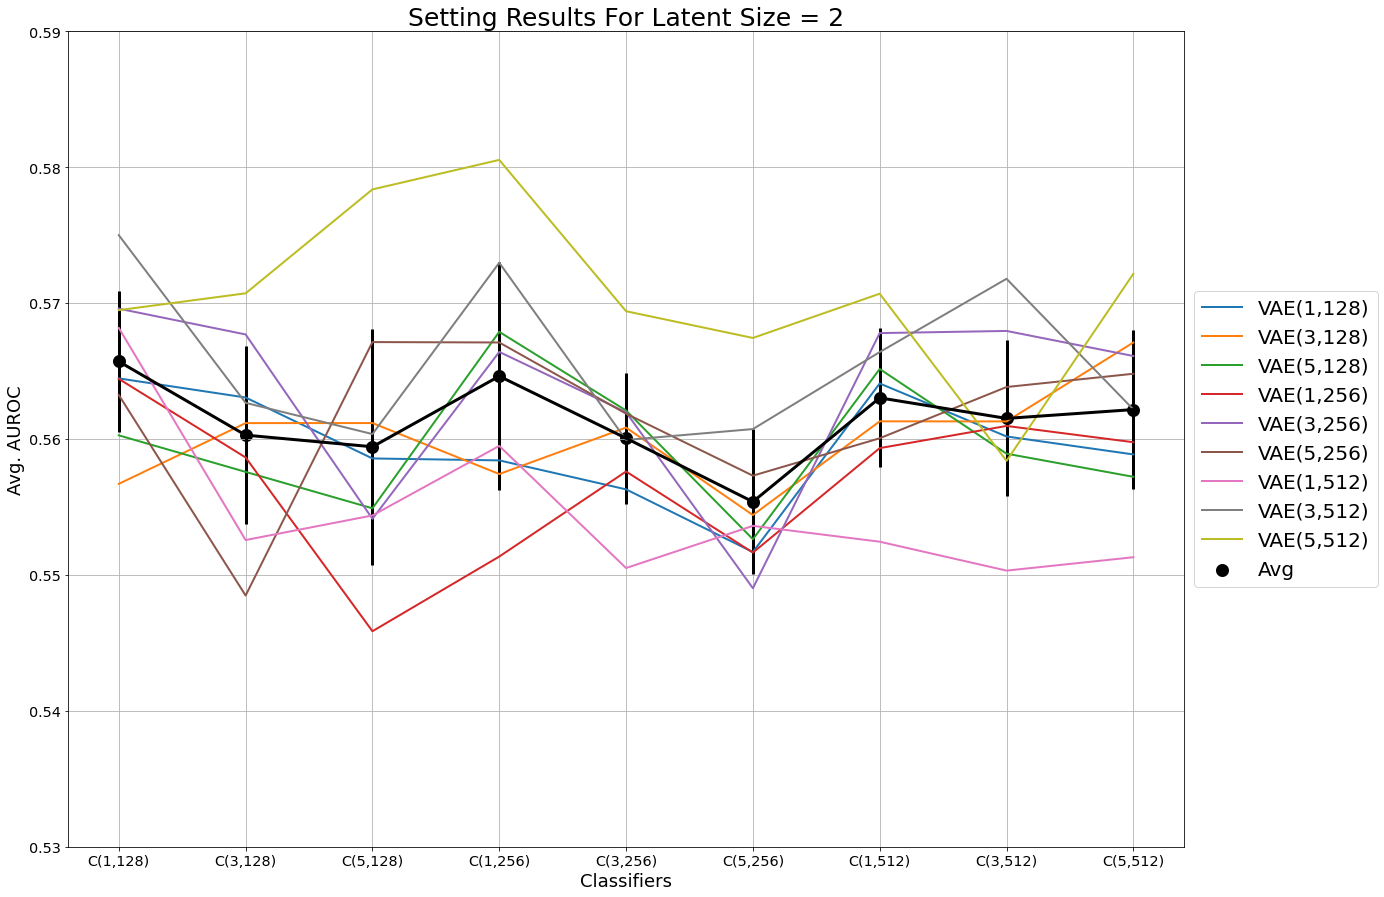

In [11]:
latent_plotter(highdim_report_step1, 2, save = True, filename = "plot_highdim_data_latent_size_2")

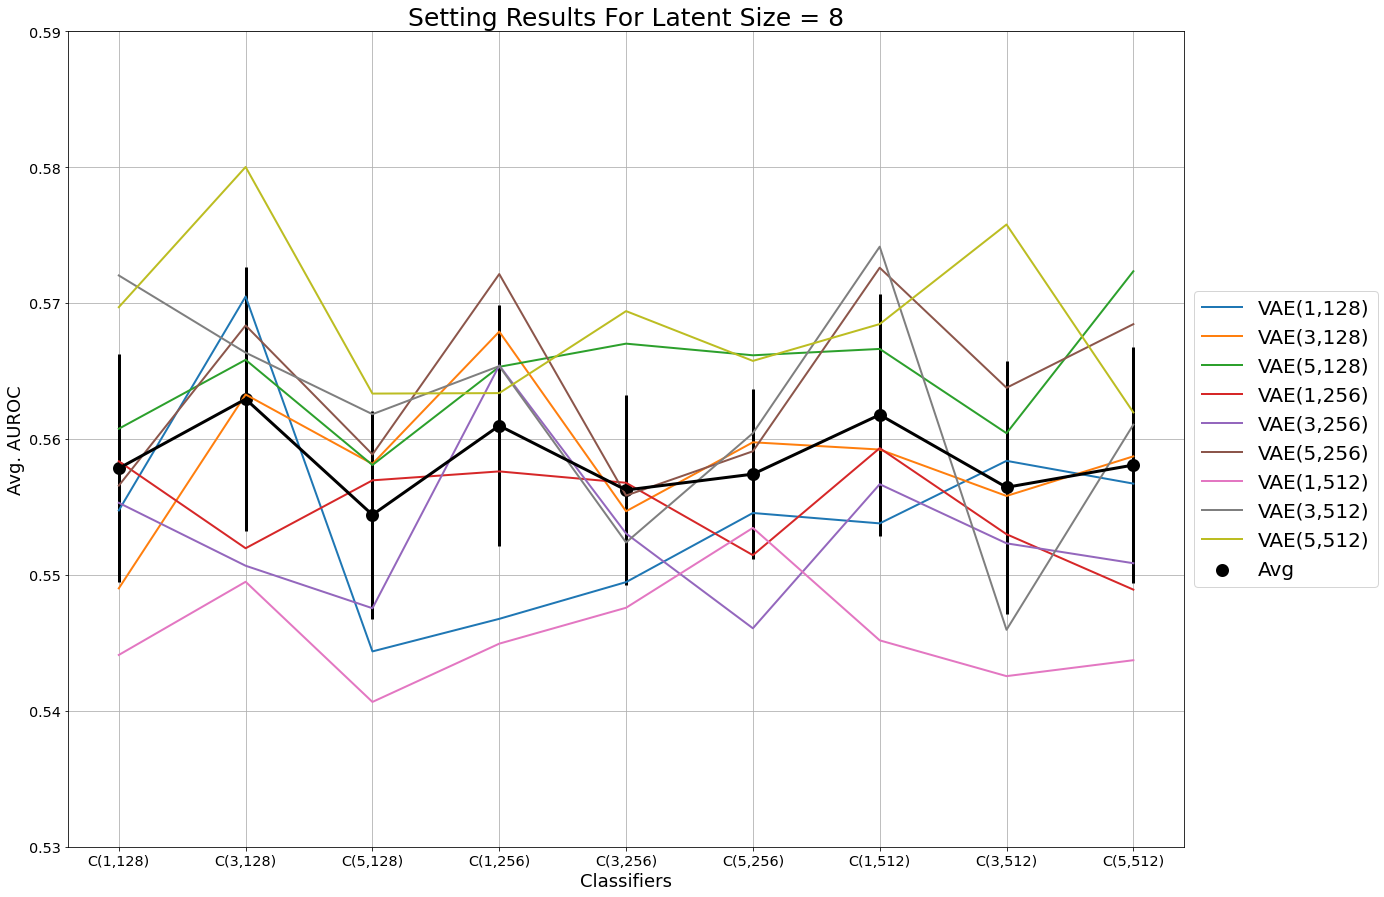

In [12]:
latent_plotter(highdim_report_step1, 8, save = True, filename = "plot_highdim_data_latent_size_8")

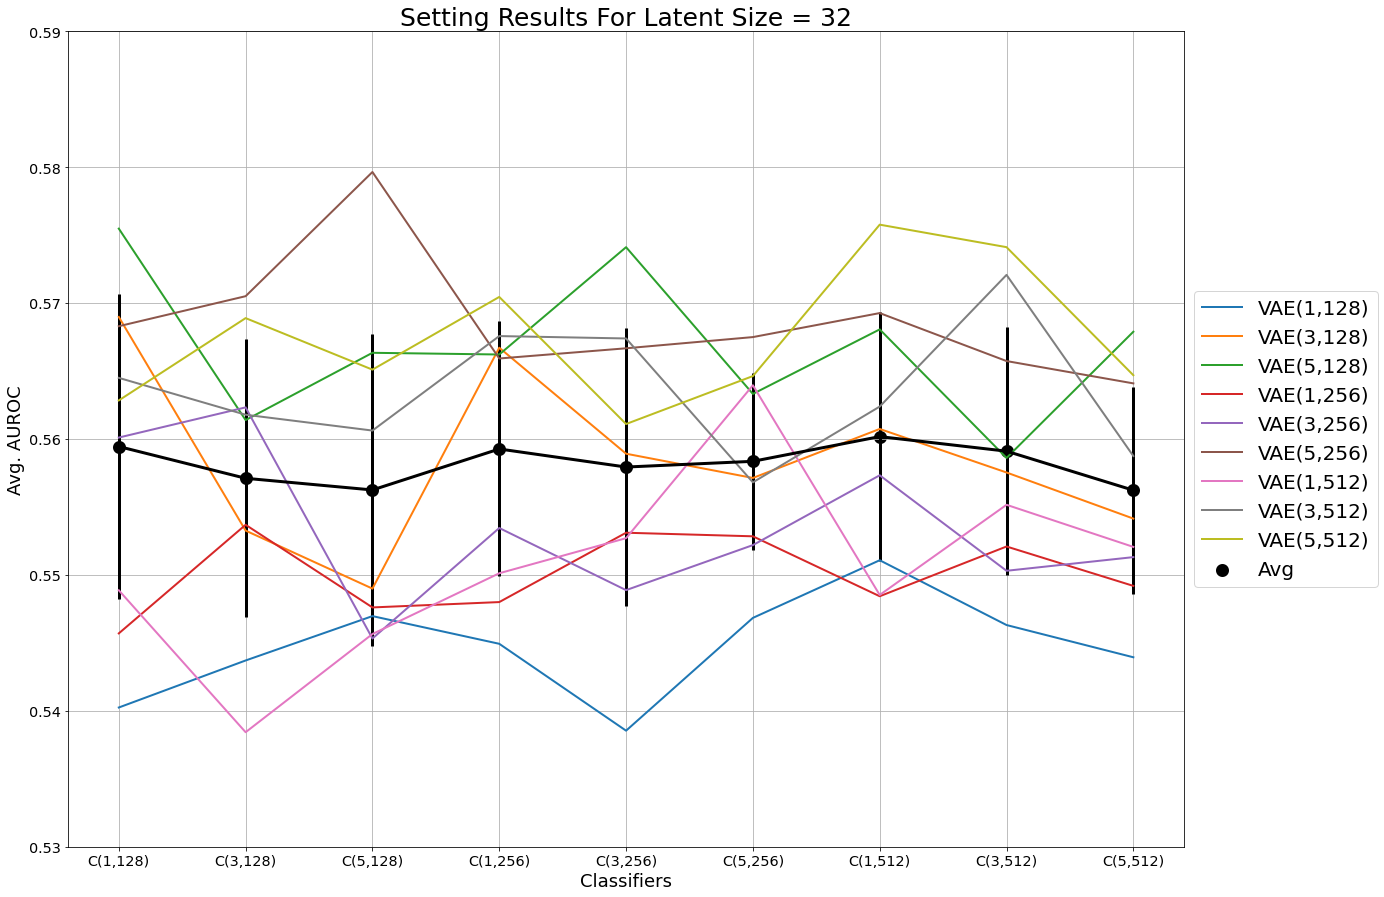

In [13]:
latent_plotter(highdim_report_step1, 32, save = True, filename = "plot_highdim_data_latent_size_32")

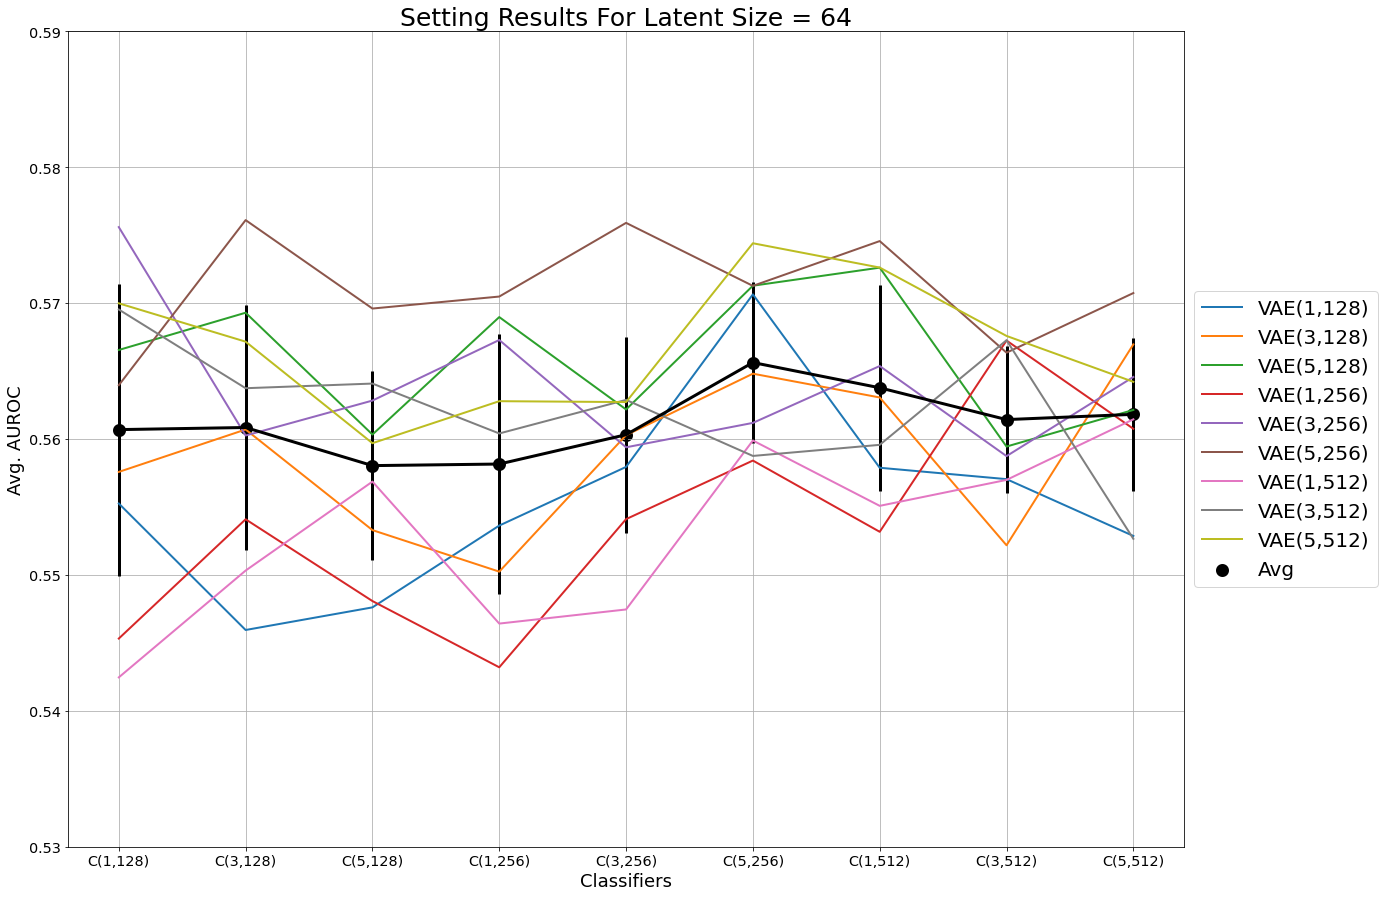

In [14]:
latent_plotter(highdim_report_step1, 64, save = True, filename = "plot_highdim_data_latent_size_64")

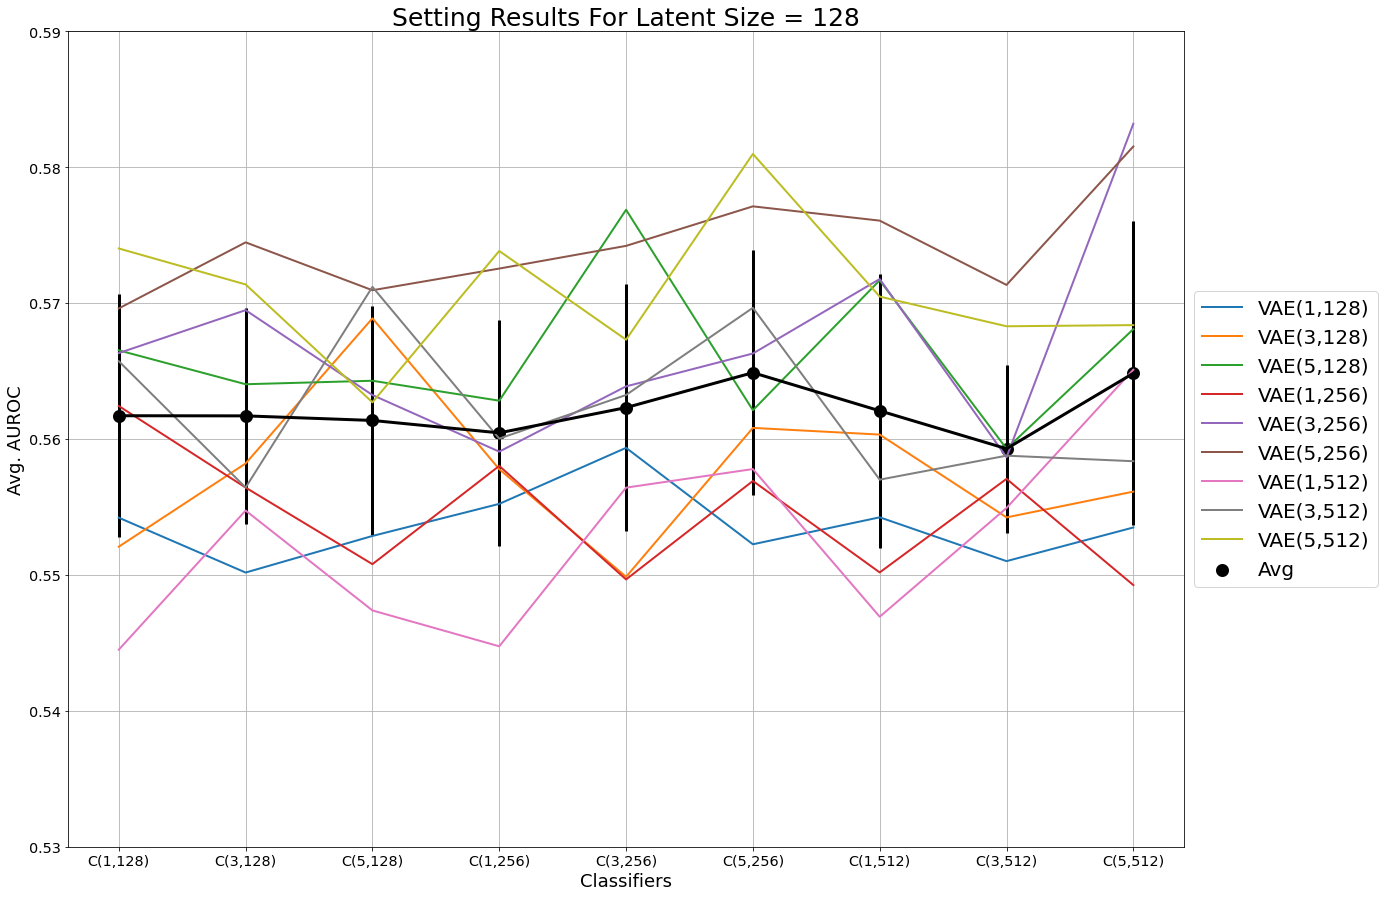

In [15]:
latent_plotter(highdim_report_step1, 128, save = True, filename = "plot_highdim_data_latent_size_128")

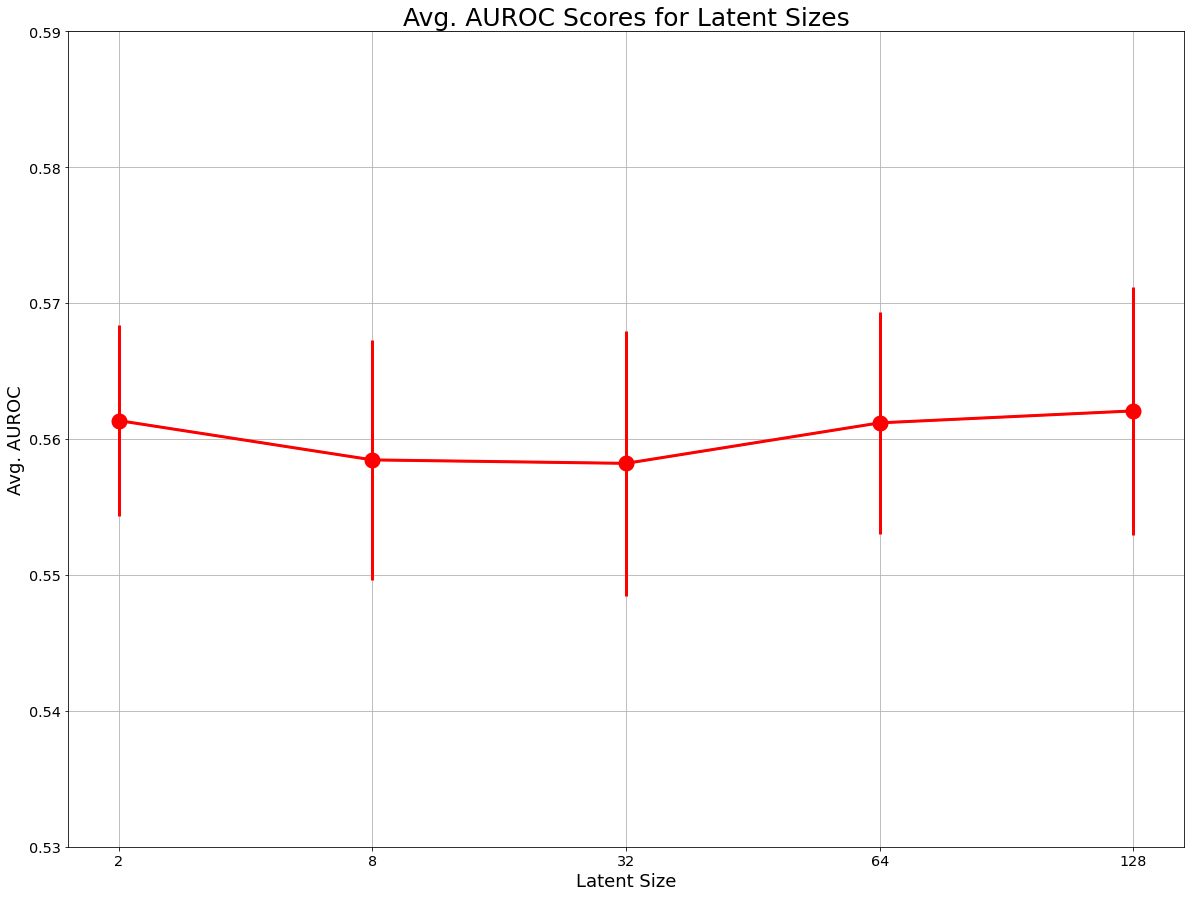

In [16]:
latent_avg(highdim_report_step1, save = True, filename = "plot_highdim_data_latent_size_avg")

### Plots for Moderate-dimensional Data

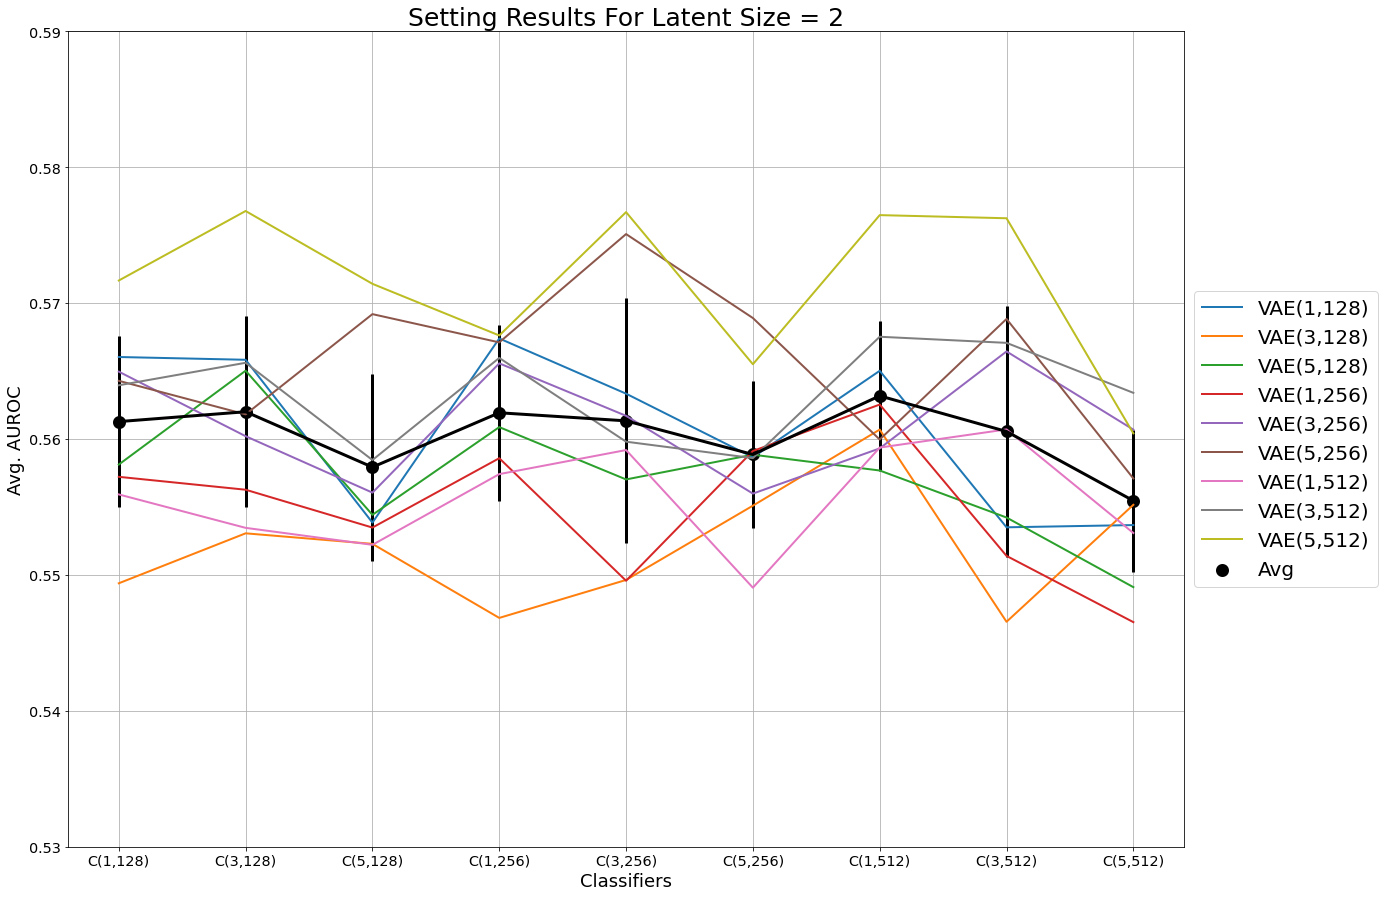

In [17]:
latent_plotter(moddim_report_step1, 2, save = True, filename = "plot_moddim_data_latent_size_2")

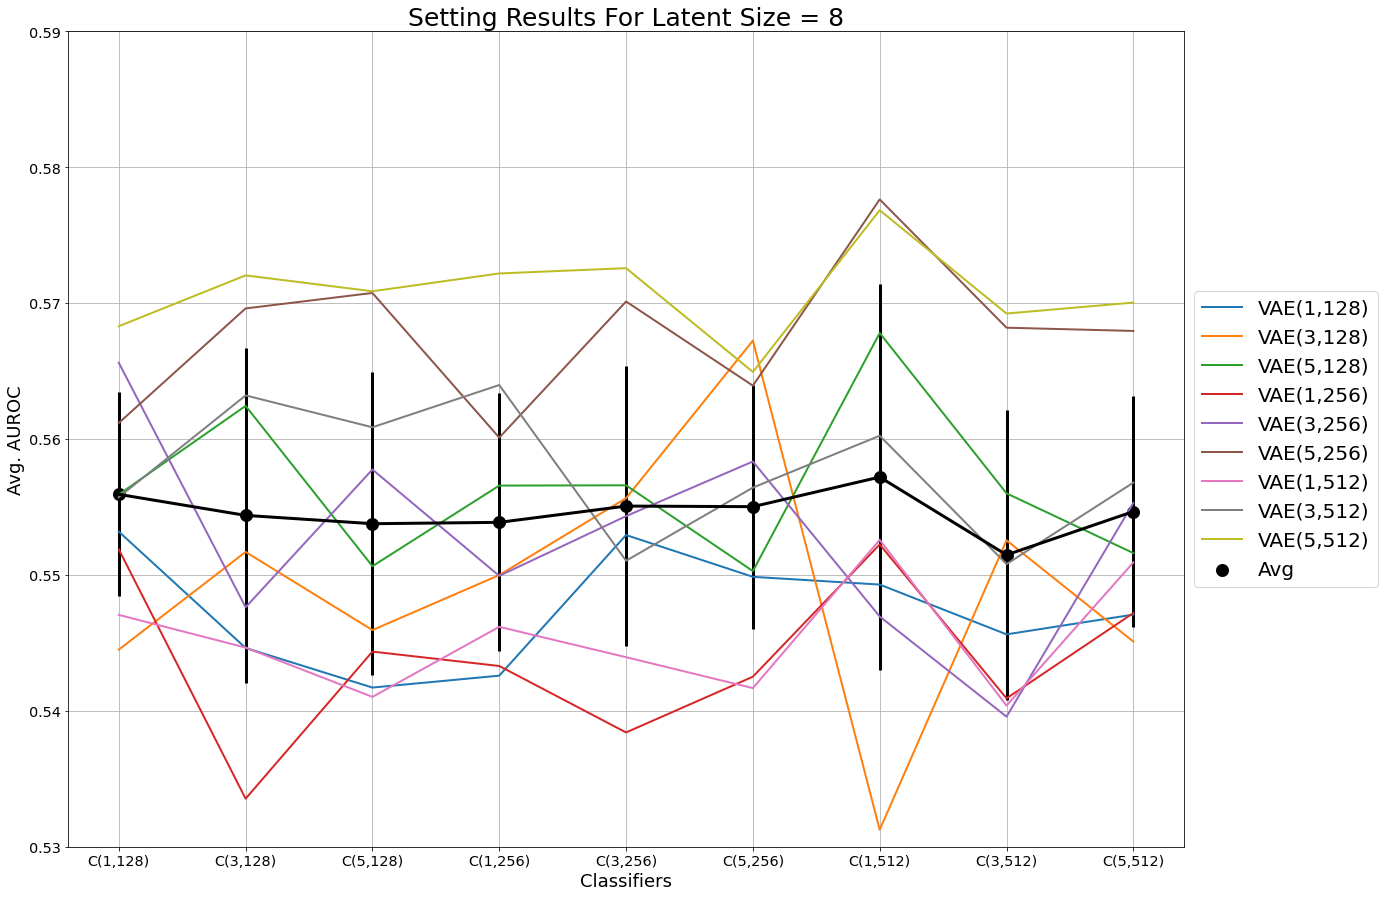

In [18]:
latent_plotter(moddim_report_step1, 8, save = True, filename = "plot_moddim_data_latent_size_8")

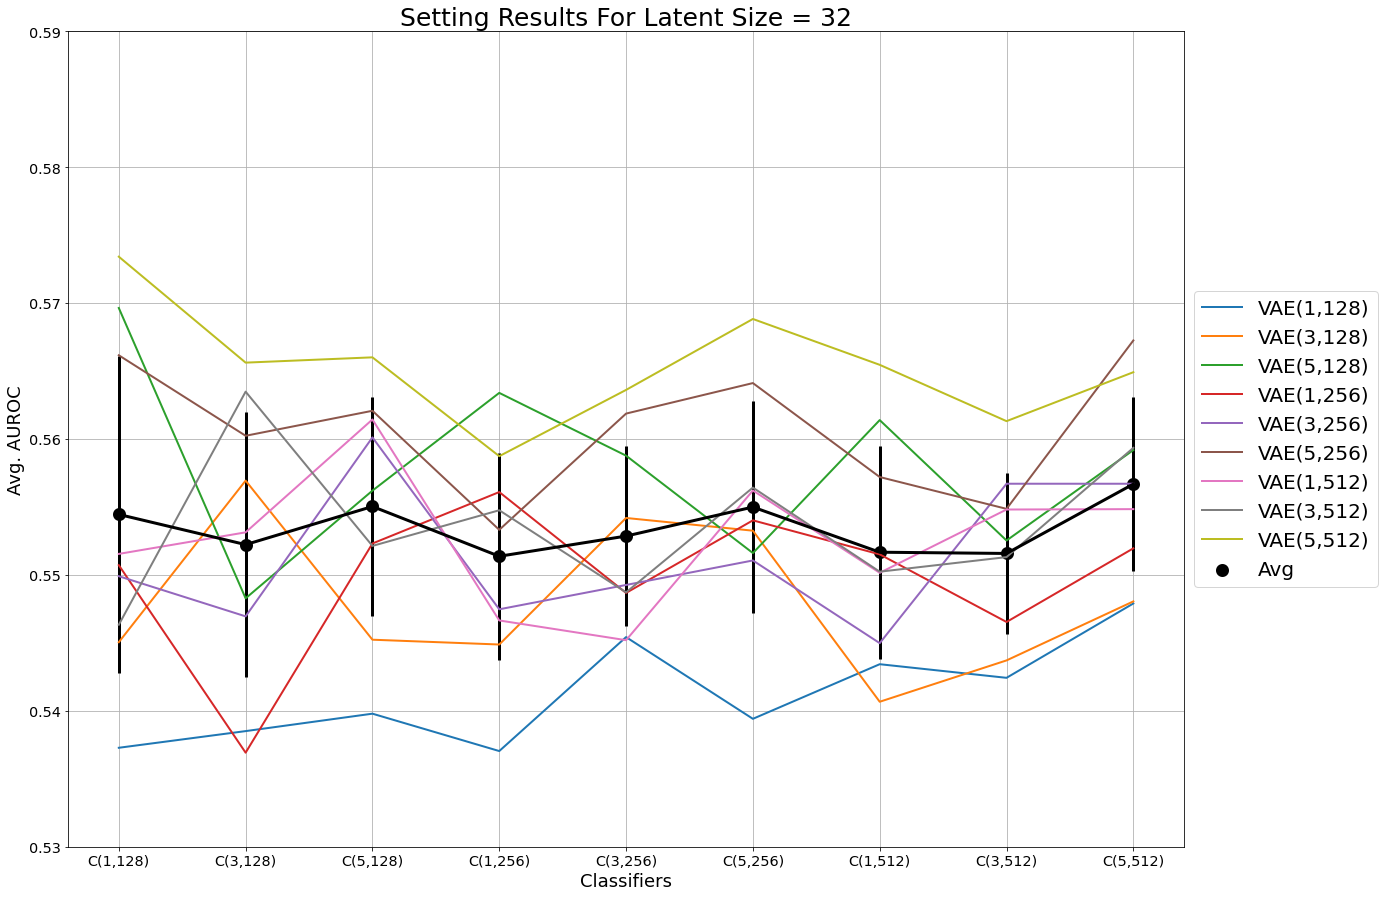

In [19]:
latent_plotter(moddim_report_step1, 32, save = True, filename = "plot_moddim_data_latent_size_32")

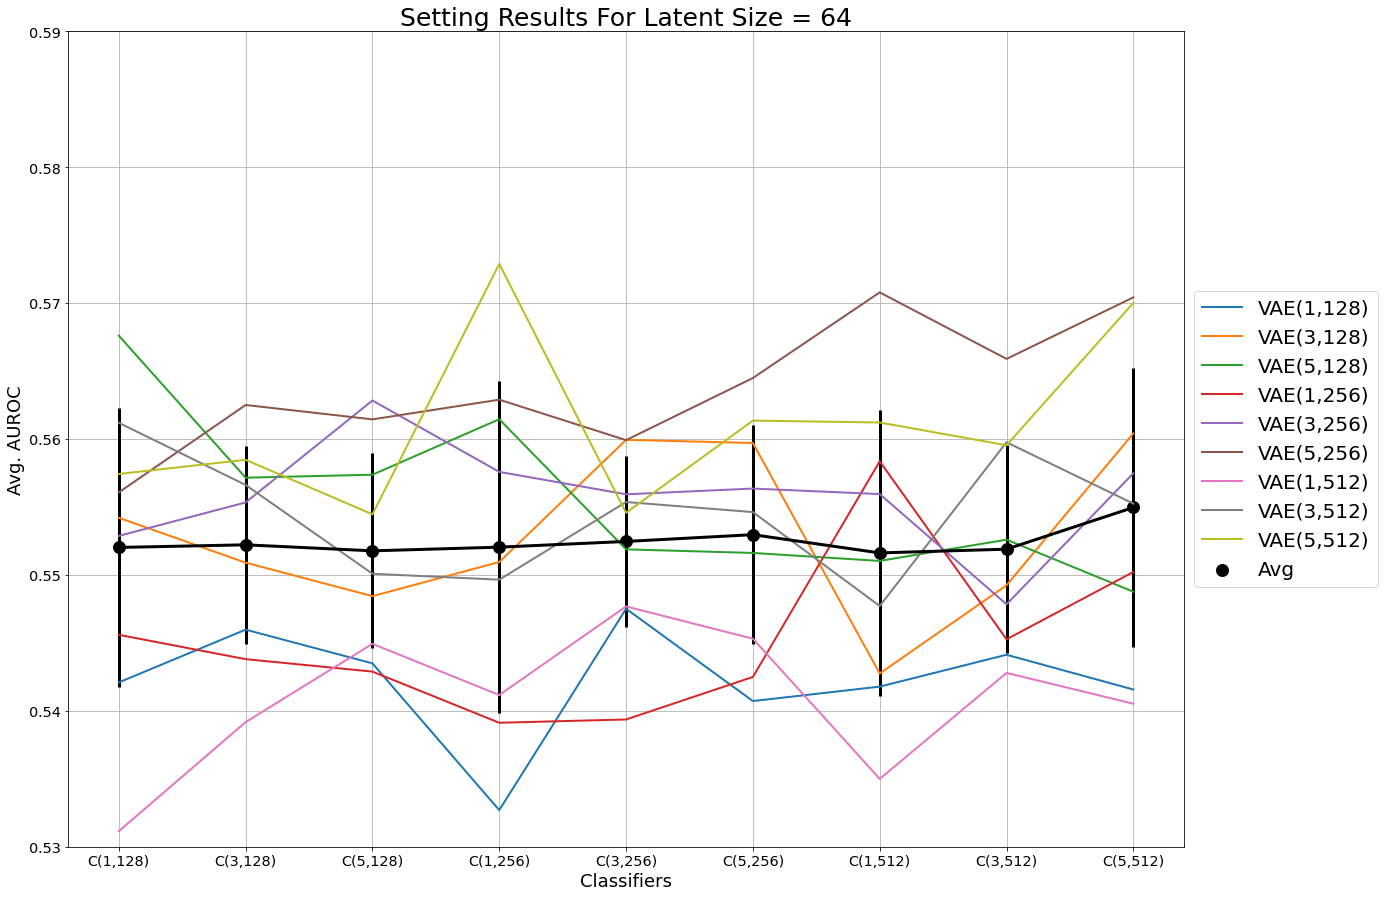

In [20]:
latent_plotter(moddim_report_step1, 64, save = True, filename = "plot_moddim_data_latent_size_64")

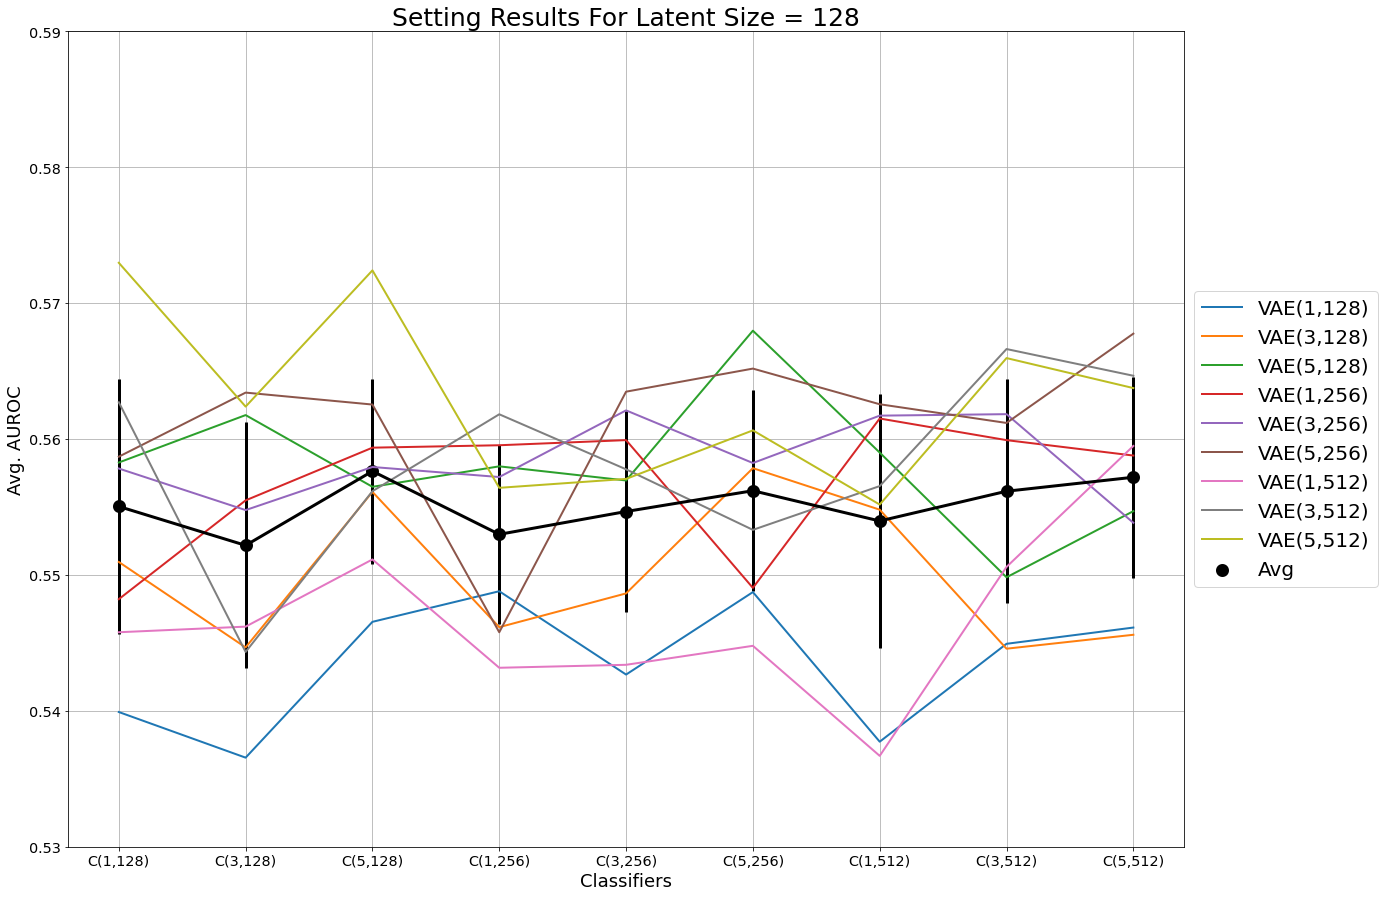

In [21]:
latent_plotter(moddim_report_step1, 128, save = True, filename = "plot_moddim_data_latent_size_128")

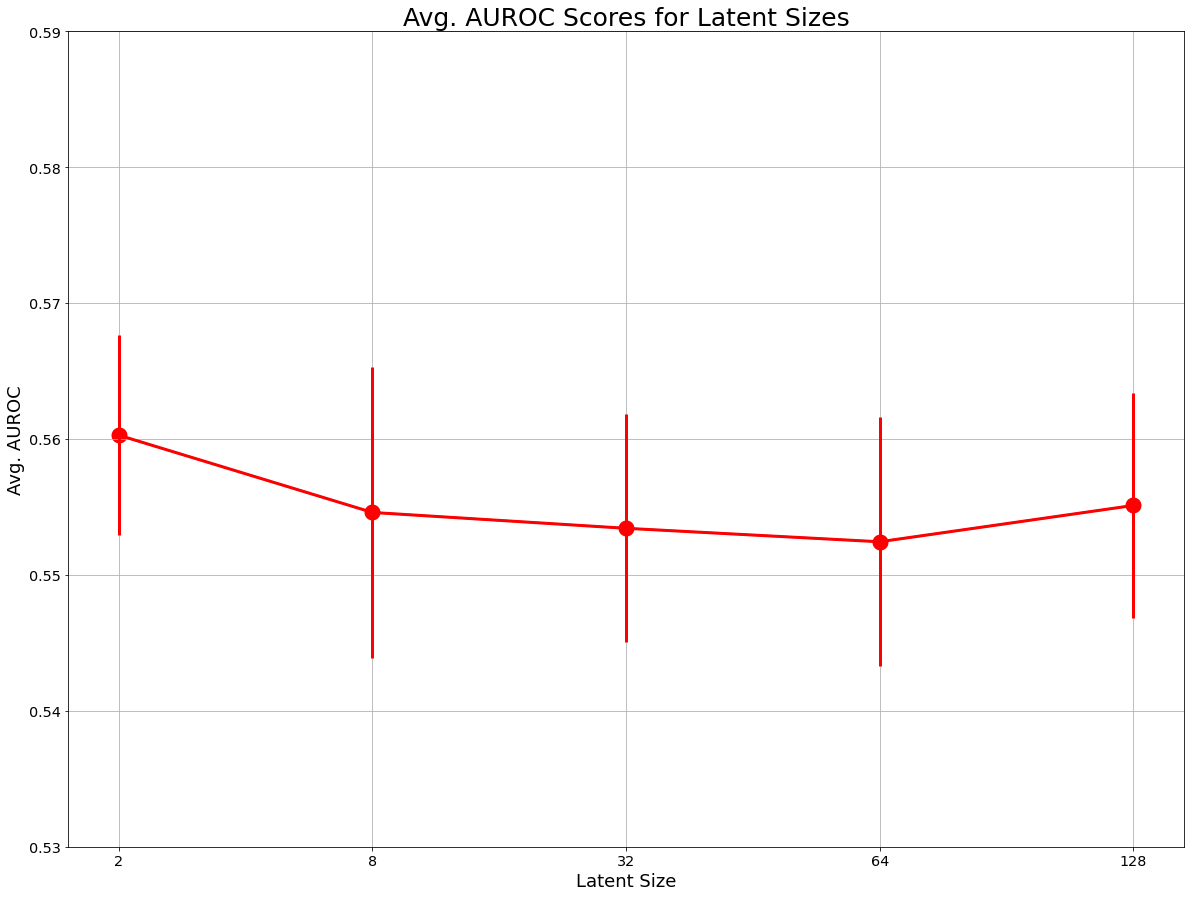

In [22]:
latent_avg(moddim_report_step1, save = True, filename = "plot_moddim_data_latent_size_avg")